## Penambahan vehicle menjadi 4 dalam 1 depot

In [1]:
pip install contextily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [3]:
# Specify the center location (latitude, longtitude)
CENTER_LOCATION = (-6.302203,	106.7919364)

# Specify distance in meters
DIST = 10000

# Specify the number of vehicles
NUM_VEHICLES = 4

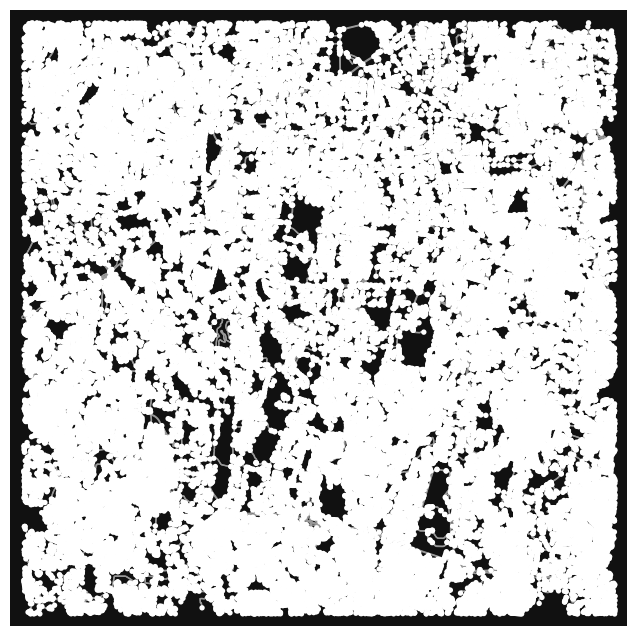

In [4]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

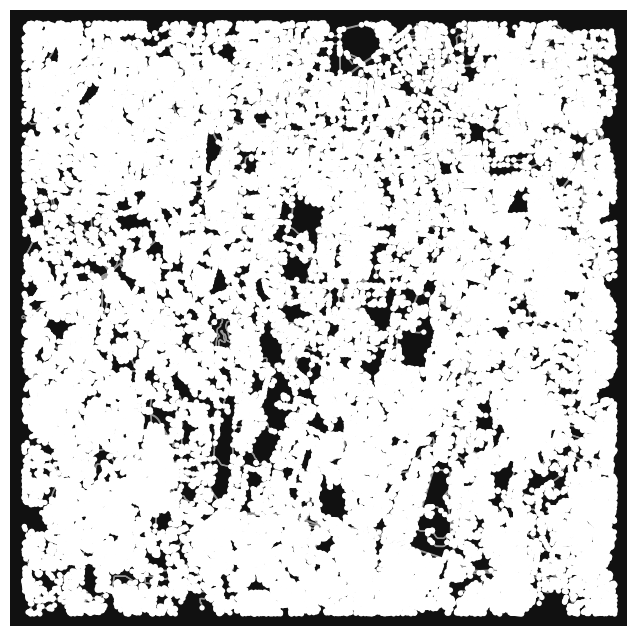

In [5]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

In [6]:
# Use the nearest node to the center location as the depot
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])
depot

3639024731

In [7]:
G

In [8]:
# Load data
import pandas as pd
data = pd.read_csv("Data_Alfamart Indomaret_South Jakarta_Filtered.csv")


In [10]:
# Rename columns
data.rename(columns={'longitude': 'lng'}, inplace=True)
data.rename(columns={'latitude': 'lat'}, inplace=True)

In [13]:
# Lakukan pengelompokan dan hitung median
district_tebet = data.groupby('place_id')[['lat', 'lng']].median().reset_index()

# Ubah nama kolom menjadi sesuai dengan yang diharapkan
district_tebet.columns = ['place_id', 'lat', 'lng']

# Tampilkan lima baris pertama
district_tebet

,place_id,lat,lng
0,ChIJ-6Meqf_xaS4R99u9vNNVFjg,-6.297004,106.815418
1,ChIJ4T8PLOPzaS4RQDVcYaC-IGg,-6.226964,106.821372
2,ChIJCZIzrZ_xaS4RiJX_wvOeaH4,-6.257676,106.796800
3,ChIJLWcbOM_xaS4RIMEFJuZjRvY,-6.285777,106.780884
4,ChIJN7p70X7xaS4R6VpOujMI_Wo,-6.255553,106.812338
5,ChIJPz4W5BPvaS4RoUnKBAiaL3o,-6.307003,106.793690
6,ChIJSXpPIvDzaS4RKSuxd1gXm2Q,-6.261301,106.828974
7,ChIJTYdPFlzzaS4R4JoaMHSAiPY,-6.224620,106.840175
8,ChIJWdlCSXPuaS4RzpIWwflyKKU,-6.320362,106.810676
9,ChIJaxj8TyDuaS4RmJ8rDkpB2GA,-6.302203,106.791936


In [14]:
# Find bus stops
bus_stops = []
for idx, row in district_tebet.iterrows():
    bus_stop = (row['lat'], row['lng'])
    bus_stops.append(bus_stop)

In [16]:
import osmnx as ox
from operator import itemgetter
from scipy.spatial import distance

In [17]:
# Find nearest nodes to bus stops
node_stop = []
for bus_stop in bus_stops:
    nearest_node = None
    min_dist = float('inf')
    for node, data in G.nodes(data=True):
        dist = distance.euclidean((data['y'], data['x']), bus_stop)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    node_stop.append(nearest_node)

print(node_stop[:5])

[2245209305, 353136643, 356236075, 7474127324, 3787028858]


In [ ]:
# Find bus stops
#bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
#bus_stop_nodes = list(map(itemgetter(1), bus_stops.index.values))
#bus_stop_nodes[:5]

C:\Users\muham\AppData\Local\Temp\ipykernel_16788\57253982.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)


[9598703117, 9742626417, 9742626418, 9742626517, 9742626518]

In [18]:
# Combine depot and bus_stops
nodes = [depot] + node_stop
nodes[:5]

[3639024731, 2245209305, 353136643, 356236075, 7474127324]

In [19]:
import geopy.distance

In [21]:
# Add bus stops to the highway graph
for idx, bus_stop in district_tebet.iterrows():
    # Temukan node terdekat di graf G
    nearest_node = ox.distance.nearest_nodes(G, bus_stop['lng'], bus_stop['lat'])
    
    # Hitung jarak antara node terdekat dan titik bus
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (bus_stop['lat'], bus_stop['lng']))
    
    # Tambahkan node bus stop ke graf
    G.add_node(bus_stop['place_id'], x=bus_stop['lng'], y=bus_stop['lat'])
    
    # Tambahkan edge dari node terdekat ke node bus stop (bidirectional)
    G.add_edge(nearest_node, bus_stop['place_id'], weight=distance.m)
    G.add_edge(bus_stop['place_id'], nearest_node, weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head(19)

osmid   
u        v          key                                                      
29939606 9504567886 0                    [558669202, 558669203, 368504612]  \
90643242 90643252   0                                            151286015   
90643252 1648652225 0         [152033152, 108350985, 152033155, 689299348]   
         90643261   0                    [152033156, 152033157, 689299350]   
90643261 5668294436 0    [114474081, 114474084, 108350984, 1257573386, ...   
         90643252   0                    [152033156, 152033157, 689299350]   
         1641060653 0                               [10560672, 1060955428]   
90643264 3369582724 0                                            151285990   
         1641060653 0                   [1185423211, 329995915, 688287663]   
90643265 5668294437 0                                            330008393   
         90643264   0                                            688287663   
90643269 90652777   0                                            151286008   
         1538010400 0                                           1223456401   
90643296 1641017989 0                                            294118781   
         2976976967 0                              [151282603, 1223456407]   
90647412 2976864345 0                                            635488317   
90647423 90647426   0                               [635488320, 736423585]   
90647426 90647427   0                                            635488320   
90647427 1641017802 0                                            634146870   

                        bridge oneway   lanes        highway width reversed   
u        v          key                                                       
29939606 9504567886 0      yes   True       1  motorway_link  3.40    False  \
90643242 90643252   0      NaN   True       1   primary_link   NaN    False   
90643252 1648652225 0      yes  False       2   primary_link   NaN     True   
         90643261   0      yes  False       2   primary_link   NaN    False   
90643261 5668294436 0      NaN   True  [2, 3]        primary   NaN    False   
         90643252   0      yes  False       2   primary_link   NaN     True   
         1641060653 0      NaN  False       2   primary_link   NaN    False   
90643264 3369582724 0      NaN   True       2       tertiary     6    False   
         1641060653 0      NaN   True  [1, 2]   primary_link   NaN    False   
90643265 5668294437 0      NaN   True       2       tertiary     6    False   
         90643264   0      NaN   True       2   primary_link   NaN    False   
90643269 90652777   0      NaN   True       2   unclassified   NaN    False   
         1538010400 0      NaN   True       2   unclassified   NaN    False   
90643296 1641017989 0      NaN  False       2   unclassified   NaN    False   
         2976976967 0      NaN   True       2   unclassified   NaN    False   
90647412 2976864345 0      NaN   True       2   unclassified   NaN    False   
90647423 90647426   0      NaN   True       2   unclassified   NaN    False   
90647426 90647427   0      NaN   True       2   unclassified   NaN    False   
90647427 1641017802 0      NaN   True       2   unclassified     6    False   

                          length                       est_width   
u        v          key                                            
29939606 9504567886 0    383.488                    [4.19, 4.27]  \
90643242 90643252   0    136.330                            6.14   
90643252 1648652225 0    215.465           [12.59, 12.90, 13.77]   
         90643261   0    315.034           [13.60, 12.90, 13.77]   
90643261 5668294436 0    663.889  [5.86, 6.56, 6.52, 5.42, 9.20]   
         90643252   0    315.034           [13.60, 12.90, 13.77]   
         1641060653 0     50.455                            4.30   
90643264 3369582724 0     28.839                             NaN   
         1641060653 0    111.895                    [3.64, 3.16]   
90643265 5668294437 0 

In [29]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(nodes), NUM_VEHICLES, nodes.index(depot))

# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [30]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [31]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [32]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [33]:
# Print the solution
total_distance = 0
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 7 -> 8 -> 17 -> 0
Distance of route: 209m

Route for vehicle 1:
0 -> 4 -> 12 -> 3 -> 19 -> 2 -> 15 -> 0
Distance of route: 209m

Route for vehicle 2:
0 -> 18 -> 16 -> 14 -> 5 -> 6 -> 0
Distance of route: 183m

Route for vehicle 3:
0 -> 10 -> 13 -> 20 -> 11 -> 9 -> 1 -> 0
Distance of route: 195m

Total distance of all routes: 796m


In [55]:
import folium

# Buat DataFrame dari list bus_stops
bus_stops_df = pd.DataFrame(bus_stops, columns=['lat', 'lng'])

# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops_df.iterrows():
    stop_coords = (bus_stop['lat'], bus_stop['lng'])
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='circle', prefix='fa'), tooltip=f"Pemberhentian {stop_coords}").add_to(m)

In [56]:
# Create colors for routes
colors = ['blue', 'orange', 'yellow', 'green']

In [57]:
# Plot routes
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % NUM_VEHICLES]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m

## Next progress: penambahan time windows dan kapasitas mobil